### Generating Feature Set for Base Model  
  
The purpose of this notebook is to generate the feature set for my base model. The features will be band power (delta, theta, alpha, beta, gamma) and sample entropy. These are calculated by channel, so each sub EEG channel will have 6 features. There are 19 EEG channels, so that means each sub EEG will have 114 features total.

In [1]:
import numpy as np
import pandas as pd
import fastparquet, pyarrow
import matplotlib.pyplot as plt
import mne
from mne.decoding import Scaler
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('by_patient.csv')

In [3]:
patient_list = np.unique(df['patient_id'])

In [4]:
def activity_df(activity):
    return pd.DataFrame(df[df['expert_consensus'] == activity]).reset_index().drop(columns = 'index')

other_df = activity_df('Other')
seizure_df = activity_df('Seizure')
lpd_df = activity_df('LPD')
gpd_df = activity_df('GPD')
lrda_df = activity_df('LRDA')
grda_df = activity_df('GRDA')

### Function to Load Sub EEG

In [5]:
def get_sub_eeg(data, row):
    whole_eeg = pd.read_parquet('train_eegs/{}.parquet'.format(data['eeg_id'][row]), engine = 'pyarrow')
    start = int(data['eeg_label_offset_seconds'][row] * 200)
    stop = start + 10000
    sub_eeg = whole_eeg[start: stop].reset_index().drop(columns = 'index')
    return sub_eeg

### Functions to Concatenate EEGs by Patient ID

In [6]:
def within_eeg(data, eeg_id):
    subset = data[data['eeg_id'] == eeg_id].copy()
    subset = subset.reset_index().drop(columns = 'index')
    eeg = pd.read_parquet('train_eegs/{}.parquet'.format(eeg_id), engine = 'pyarrow')
    full = eeg[0:10000].copy()
    for i in range(1, subset.shape[0]):
        start = int(subset['eeg_label_offset_seconds'][i] * 200)
        stop = start + 10000
        sub_eeg = eeg[start:stop].copy()
        full = pd.concat([full, sub_eeg])
    return full.reset_index().drop(columns = 'index')

In [7]:
def within_patient(data, patient):
    patient_data = data[data['patient_id'] == patient].copy()
    patient_data = patient_data.reset_index().drop(columns = 'index')
    unique_eegs = np.unique(patient_data['eeg_id'])
    full = within_eeg(patient_data, unique_eegs[0])
    for i in range(1, len(unique_eegs)):
        eeg = within_eeg(patient_data, unique_eegs[i])
        full = pd.concat([full, eeg])
    return full.reset_index().drop(columns = 'index')

### Scaling with Scikit-Learn  
  
I've written two functions to scale EEG data by channel. I'm going to use these functions and then load in the scaled data and generate epochs with MNE. Eventually, I'd like to use MNE's scaler to do this, but I'm having some difficulty getting the scaler to transform the data in place. My best alternative right now seems to be setting a new variable equal to the transformed data and loading that in with MNE, but I'm a bit confused by the dimensionality of the epoched data. When I load in the raw data at first, it's two dimensions. When I establish epochs, it's three dimensions. If I load that back in, will MNE treat it as already epoched? I need to figure these things out, but I also need to get base model results for tomorrow.

In [8]:
def standardize_channel(eeg, channel):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(eeg[[channel]]).flatten()
    return scaled

def standardize_eeg(eeg):
    channels = eeg.columns
    for channel in channels:
        eeg[channel] = standardize_channel(eeg, channel)
    return eeg

In [9]:
patient1 = within_patient(df, patient_list[0])
patient1_scaled = standardize_eeg(patient1)

### Loading in First Patient with MNE

In [10]:
info = mne.create_info(
    patient1_scaled.columns.to_list(),
    ch_types=(["eeg"]*(len(patient1_scaled.columns)-1))+['ecg'],
    sfreq=200
)
info.set_montage("standard_1020")

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,"19 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,EKG
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


In [11]:
raw = mne.io.RawArray(
    patient1_scaled.to_numpy().T,
    info
)

Creating RawArray with float64 data, n_channels=20, n_times=520000
    Range : 0 ... 519999 =      0.000 ...  2599.995 secs
Ready.


In [12]:
from mne_features.univariate import compute_samp_entropy, compute_pow_freq_bands

In [13]:
channels = raw.ch_names

electrodes = []
for i in range(len(channels)):
    if channels[i] != 'EKG':
        electrodes.append(channels[i])

In [14]:
freq_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
band_features = []
for e in electrodes:
    for b in freq_bands:
        feat_name = '{}_{}'.format(e, b)
        band_features.append(feat_name)

### Functions for Loading Sub EEGs and Generating Feature Set  
  
I think for the base model, I'm going to go back to pulling individual sub EEGs at random rather than pulling patients at random. Sub EEGs are already large. 10k instances for every channel should be enough for scaling. Maybe it's ideal to scale all patient data together, but I'm running into issues running that code and I need to get base model results.  
  
The code below will load sub EEGs into MNE and then load those into a list of RawArray objects. That list will be looped over and each sub EEG will have band power feature data calculated for it.

In [15]:
def raw_array(data, row):
    sub_eeg = get_sub_eeg(data, row)
    scaled_eeg = standardize_eeg(sub_eeg)
    info = mne.create_info(
        scaled_eeg.columns.to_list(),
        ch_types=(["eeg"]*(len(scaled_eeg.columns)-1))+['ecg'],
        sfreq=200
    )
    info.set_montage("standard_1020")
    
    raw = mne.io.RawArray(
        scaled_eeg.to_numpy().T,
        info
    )
    return raw

In [16]:
def get_band_features(data):
    band_powers = compute_pow_freq_bands(200, data)
    return pd.DataFrame(band_powers, index = band_features).transpose()

### Band Features for Other

In [17]:
other_rows = [i for i in range(other_df.shape[0])]
random_other = np.random.choice(other_rows, size = 850, replace = False)

In [18]:
other_bands_df = pd.DataFrame()
for i in random_other:
    sub_eeg = raw_array(other_df, i)
    bands = get_band_features(sub_eeg.get_data(picks = 'eeg'))
    other_bands_df = pd.concat([other_bands_df, bands], ignore_index = True)

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

### Band Features for Seizure

In [19]:
seizure_rows = [i for i in range(seizure_df.shape[0])]
random_seizure = np.random.choice(seizure_rows, size = 850, replace = False)

In [20]:
seizure_bands_df = pd.DataFrame()
for i in random_seizure:
    sub_eeg = raw_array(seizure_df, i)
    bands = get_band_features(sub_eeg.get_data(picks = 'eeg'))
    seizure_bands_df = pd.concat([seizure_bands_df, bands], ignore_index = True)

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

### Band Features for LPD

In [21]:
lpd_rows = [i for i in range(lpd_df.shape[0])]
random_lpd = np.random.choice(lpd_rows, size = 850, replace = False)

In [22]:
lpd_bands_df = pd.DataFrame()
for i in random_lpd:
    sub_eeg = raw_array(lpd_df, i)
    bands = get_band_features(sub_eeg.get_data(picks = 'eeg'))
    lpd_bands_df = pd.concat([lpd_bands_df, bands], ignore_index = True)

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

### Band Features for GPD

In [23]:
gpd_rows = [i for i in range(gpd_df.shape[0])]
random_gpd = np.random.choice(gpd_rows, size = 850, replace = False)

In [24]:
gpd_bands_df = pd.DataFrame()
for i in random_gpd:
    sub_eeg = raw_array(gpd_df, i)
    bands = get_band_features(sub_eeg.get_data(picks = 'eeg'))
    gpd_bands_df = pd.concat([gpd_bands_df, bands], ignore_index = True)

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

### Band Features for LRDA

In [25]:
lrda_rows = [i for i in range(lrda_df.shape[0])]
random_lrda = np.random.choice(lrda_rows, size = 850, replace = False)

In [26]:
lrda_bands_df = pd.DataFrame()
for i in random_lrda:
    sub_eeg = raw_array(lrda_df, i)
    bands = get_band_features(sub_eeg.get_data(picks = 'eeg'))
    lrda_bands_df = pd.concat([lrda_bands_df, bands], ignore_index = True)

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

### Band Features for GRDA

In [27]:
grda_rows = [i for i in range(grda_df.shape[0])]
random_grda = np.random.choice(grda_rows, size = 850, replace = False)

In [28]:
grda_bands_df = pd.DataFrame()
for i in random_grda:
    sub_eeg = raw_array(grda_df, i)
    bands = get_band_features(sub_eeg.get_data(picks = 'eeg'))
    grda_bands_df = pd.concat([grda_bands_df, bands], ignore_index = True)

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ..

    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Creating RawArray with float64 data, n_cha

In [29]:
bands_by_type = [other_bands_df, seizure_bands_df, lpd_bands_df, gpd_bands_df, 
                lrda_bands_df, grda_bands_df]
band_features_df = pd.DataFrame()
for b in bands_by_type:
    band_features_df = pd.concat([band_features_df, b], ignore_index = True)

In [30]:
band_features_df

,Fp1_delta,Fp1_theta,Fp1_alpha,Fp1_beta,Fp1_gamma,F3_delta,F3_theta,F3_alpha,F3_beta,F3_gamma,...,T6_delta,T6_theta,T6_alpha,T6_beta,T6_gamma,O2_delta,O2_theta,O2_alpha,O2_beta,O2_gamma
0,0.821503,0.018575,0.004497,0.004441,0.003312,0.794748,0.028111,0.012300,0.030312,0.079252,...,0.790638,0.044591,0.017062,0.033814,0.066139,0.854777,0.036470,0.013885,0.023823,0.035766
1,0.838551,0.043799,0.017623,0.021772,0.022089,0.846907,0.051757,0.017463,0.020397,0.018139,...,0.889386,0.008245,0.003437,0.004636,0.004508,0.842335,0.048463,0.016173,0.019525,0.015926
2,0.816626,0.068914,0.012720,0.017508,0.039130,0.733933,0.129459,0.023805,0.032237,0.051639,...,0.347323,0.016838,0.011965,0.135544,0.461927,0.766311,0.057196,0.014069,0.023158,0.094503
3,0.641029,0.040111,0.016097,0.069631,0.175476,0.537726,0.055198,0.022013,0.109811,0.232948,...,0.503861,0.039999,0.027460,0.110527,0.284447,0.425861,0.034133,0.029216,0.136584,0.339766
4,0.861911,0.057003,0.019549,0.009595,0.012824,0.535843,0.040419,0.013727,0.006479,0.377799,...,0.853326,0.064699,0.023659,0.010676,0.016158,0.865705,0.052612,0.018362,0.008342,0.011617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5095,0.822480,0.034721,0.021834,0.029986,0.056557,0.686477,0.060503,0.057754,0.068667,0.090160,...,0.505288,0.072585,0.061908,0.124606,0.210448,0.624046,0.086455,0.083747,0.071973,0.102156
5096,0.896839,0.041549,0.002733,0.007598,0.031952,0.847669,0.048562,0.004029,0.016694,0.059689,...,0.714904,0.048326,0.008667,0.049292,0.143424,0.862103,0.041227,0.005479,0.015615,0.036694
5097,0.917460,0.016260,0.002525,0.001001,0.001977,0.917576,0.016659,0.002544,0.001788,0.004212,...,0.903866,0.019591,0.002705,0.001350,0.004349,0.879574,0.020759,0.003269,0.001423,0.011030
5098,0.868700,0.009916,0.001161,0.000547,0.035368,0.389900,0.014832,0.002003,0.001129,0.561683,...,0.580899,0.016457,0.001652,0.001366,0.351700,0.478768,0.009717,0.001235,0.000553,0.464964


In [31]:
y_values = []
for i in range(850):
    y_values.append('Other')
for i in range(850):
    y_values.append('Seizure')
for i in range(850):
    y_values.append('LPD')
for i in range(850):
    y_values.append('GPD')
for i in range(850):
    y_values.append('LRDA')
for i in range(850):
    y_values.append('GRDA')

In [32]:
y_values = pd.DataFrame(y_values, columns = ['Activity Type'])

### Base Model 1: DecisionTreeClassifier  
  
The current thought is to use RandomForest for my final model, but base models should prioritize simplicity when possible. A Decision Tree accomplishes that here. The current feature set is 3000 rows by 95 columns. The columns represent a power within one of five frequency bands. These five band powers are calculated for every channel of 3000 sub EEGs. 5 frequency bands for 19 EEG channels results in 95 feature columns. To generate the feature set, I pulled 500 sub EEGs at random from each category of the target variable. I might go back and increase that number before running these models.

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [34]:
scaler = StandardScaler()
band_features_df = scaler.fit_transform(band_features_df)

In [35]:
band_features_df = pd.DataFrame(band_features_df, columns = band_features)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(band_features_df, y_values, test_size = 0.3, 
                                                    random_state = 42)

In [37]:
X_train, X_test = X_train.reset_index().drop(columns = 'index'), X_test.reset_index().drop(columns = 'index')
y_train, y_test = y_train.reset_index().drop(columns = 'index'), y_test.reset_index().drop(columns = 'index')

In [38]:
training_tree = DecisionTreeClassifier(random_state = 52)
training_tree.fit(X_train, y_train)
yhat = training_tree.predict(X_train)

In [39]:
training_results = classification_report(y_train, yhat)

In [85]:
print('Decision Tree Training')
print(training_results)

Decision Tree Training
              precision    recall  f1-score   support

         GPD       1.00      1.00      1.00       613
        GRDA       1.00      1.00      1.00       582
         LPD       1.00      1.00      1.00       594
        LRDA       1.00      1.00      1.00       604
       Other       1.00      1.00      1.00       567
     Seizure       1.00      1.00      1.00       610

    accuracy                           1.00      3570
   macro avg       1.00      1.00      1.00      3570
weighted avg       1.00      1.00      1.00      3570



In [41]:
testing_tree = DecisionTreeClassifier(random_state = 52)
testing_tree.fit(X_train, y_train)
yhat = testing_tree.predict(X_test)
testing_results = classification_report(y_test, yhat)

              precision    recall  f1-score   support

         GPD       0.59      0.68      0.63       237
        GRDA       0.46      0.50      0.48       268
         LPD       0.48      0.46      0.47       256
        LRDA       0.57      0.54      0.55       246
       Other       0.35      0.29      0.31       283
     Seizure       0.39      0.40      0.39       240

    accuracy                           0.47      1530
   macro avg       0.47      0.48      0.47      1530
weighted avg       0.47      0.47      0.47      1530



In [86]:
print('Decision Tree Testing')
print(testing_results)

Decision Tree Testing
              precision    recall  f1-score   support

         GPD       0.59      0.68      0.63       237
        GRDA       0.46      0.50      0.48       268
         LPD       0.48      0.46      0.47       256
        LRDA       0.57      0.54      0.55       246
       Other       0.35      0.29      0.31       283
     Seizure       0.39      0.40      0.39       240

    accuracy                           0.47      1530
   macro avg       0.47      0.48      0.47      1530
weighted avg       0.47      0.47      0.47      1530



In [73]:
from sklearn.metrics import f1_score, accuracy_score

In [74]:
test_f1 = f1_score(y_test, yhat, average = None)
test_f1_weighted = f1_score(y_test, yhat, average = 'weighted')
tree_test_acc = accuracy_score(y_test, yhat)

In [75]:
test_f1

array([0.63157895, 0.47771836, 0.46825397, 0.55114823, 0.31334623,
       0.3909465 ])

In [76]:
test_f1_weighted

0.4677597081370569

In [77]:
tree_test_acc

0.4718954248366013

### Base Model 2: KNN Classification  
  
Because I'm dealing with standardized numeric features, it makes sense to use an algorithm like KNN to distinguish sub EEGs by activity type.

In [43]:
training_knn = KNeighborsClassifier()
training_knn.fit(X_train, y_train['Activity Type'])
training_yhat = training_knn.predict(X_train)
training_results2 = classification_report(y_train['Activity Type'], training_yhat)

              precision    recall  f1-score   support

         GPD       0.74      0.88      0.80       613
        GRDA       0.61      0.80      0.69       582
         LPD       0.67      0.79      0.73       594
        LRDA       0.74      0.77      0.75       604
       Other       0.65      0.45      0.53       567
     Seizure       0.81      0.49      0.61       610

    accuracy                           0.70      3570
   macro avg       0.71      0.70      0.69      3570
weighted avg       0.71      0.70      0.69      3570



In [83]:
print('KNN Training')
print(training_results2)

KNN Training
              precision    recall  f1-score   support

         GPD       0.74      0.88      0.80       613
        GRDA       0.61      0.80      0.69       582
         LPD       0.67      0.79      0.73       594
        LRDA       0.74      0.77      0.75       604
       Other       0.65      0.45      0.53       567
     Seizure       0.81      0.49      0.61       610

    accuracy                           0.70      3570
   macro avg       0.71      0.70      0.69      3570
weighted avg       0.71      0.70      0.69      3570



In [44]:
testing_knn = KNeighborsClassifier()
testing_knn.fit(X_train, y_train['Activity Type'])
testing_yhat = testing_knn.predict(X_test)
testing_results2 = classification_report(y_test['Activity Type'], testing_yhat)

              precision    recall  f1-score   support

         GPD       0.59      0.81      0.68       237
        GRDA       0.51      0.69      0.59       268
         LPD       0.56      0.68      0.61       256
        LRDA       0.58      0.60      0.59       246
       Other       0.51      0.28      0.36       283
     Seizure       0.57      0.28      0.37       240

    accuracy                           0.55      1530
   macro avg       0.55      0.56      0.53      1530
weighted avg       0.55      0.55      0.53      1530



In [84]:
print('KNN Testing')
print(testing_results2)

KNN Testing
              precision    recall  f1-score   support

         GPD       0.59      0.81      0.68       237
        GRDA       0.51      0.69      0.59       268
         LPD       0.56      0.68      0.61       256
        LRDA       0.58      0.60      0.59       246
       Other       0.51      0.28      0.36       283
     Seizure       0.57      0.28      0.37       240

    accuracy                           0.55      1530
   macro avg       0.55      0.56      0.53      1530
weighted avg       0.55      0.55      0.53      1530



In [78]:
knn_test_f1 = f1_score(y_test['Activity Type'], testing_yhat, average = None)
knn_test_f1_weighted = f1_score(y_test['Activity Type'], testing_yhat, average = 'weighted')
knn_test_acc = accuracy_score(y_test['Activity Type'], testing_yhat)

In [79]:
testing_accs = [tree_test_acc, knn_test_acc]
testing_f1 = [test_f1_weighted, knn_test_f1_weighted]
models = ['Decision Tree', 'KNN']

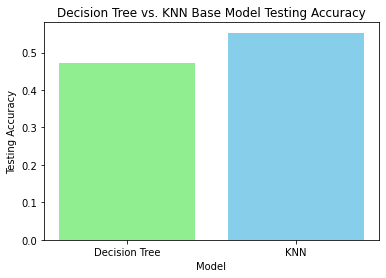

In [80]:
import matplotlib.pyplot as plt

plt.bar(models, testing_accs, color = ['lightgreen', 'skyblue'])
plt.title('Decision Tree vs. KNN Base Model Testing Accuracy')
plt.xlabel('Model')
plt.ylabel('Testing Accuracy')
plt.show()

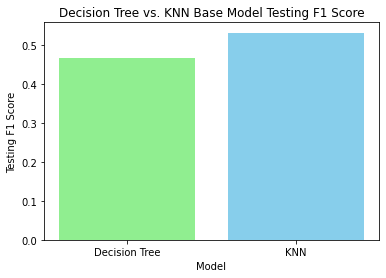

In [81]:
plt.bar(models, testing_f1, color = ['lightgreen', 'skyblue'])
plt.title('Decision Tree vs. KNN Base Model Testing F1 Score')
plt.xlabel('Model')
plt.ylabel('Testing F1 Score')
plt.show()

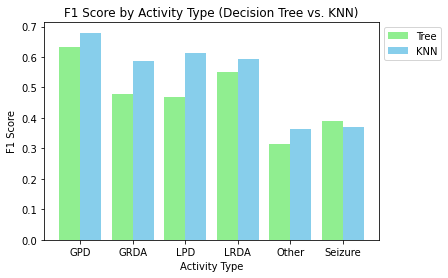

In [82]:
activity_evaluation = ['GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure']

X_axis = np.arange(len(activity_evaluation))

plt.bar(X_axis - 0.2, test_f1, 0.4, label = 'Tree', color = 'lightgreen') 
plt.bar(X_axis + 0.2, knn_test_f1, 0.4, label = 'KNN', color = 'skyblue') 
  
plt.xticks(X_axis, activity_evaluation)
plt.xlabel('Activity Type') 
plt.ylabel('F1 Score') 
plt.title('F1 Score by Activity Type (Decision Tree vs. KNN)')
plt.legend(bbox_to_anchor = [1, 1], loc = 'upper left') 
plt.show()

In [50]:
850 / df['expert_consensus'].value_counts()

expert_consensus
Seizure    0.050789
Other      0.056437
GPD        0.066432
GRDA       0.066782
LRDA       0.071639
LPD        0.076254
Name: count, dtype: float64

In [51]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.
 |  
 |  max_d

In [52]:
band_features_df

,Fp1_delta,Fp1_theta,Fp1_alpha,Fp1_beta,Fp1_gamma,F3_delta,F3_theta,F3_alpha,F3_beta,F3_gamma,...,T6_delta,T6_theta,T6_alpha,T6_beta,T6_gamma,O2_delta,O2_theta,O2_alpha,O2_beta,O2_gamma
0,0.732089,-0.740480,-0.701127,-0.553155,-0.687913,0.729301,-0.705040,-0.556828,-0.212251,-0.429251,...,0.909849,-0.539059,-0.518516,-0.336678,-0.582779,1.096955,-0.634826,-0.561894,-0.387185,-0.654189
1,0.801188,-0.386620,-0.285305,-0.264317,-0.616483,0.929465,-0.387790,-0.413389,-0.357447,-0.642623,...,1.284961,-1.046946,-0.828015,-0.716427,-0.798923,1.049875,-0.467686,-0.509978,-0.446187,-0.721761
2,0.712325,-0.034292,-0.440627,-0.335377,-0.551654,0.495923,0.654710,-0.237240,-0.184048,-0.525659,...,-0.774161,-0.926876,-0.634301,0.987347,0.805258,0.762190,-0.345977,-0.557712,-0.396314,-0.454145
3,0.000600,-0.438362,-0.333669,0.533296,-0.032964,-0.257027,-0.341622,-0.286998,0.951978,0.107371,...,-0.179523,-0.603225,-0.282319,0.661750,0.182832,-0.526107,-0.667399,-0.213955,1.160655,0.381168
4,0.895873,-0.201388,-0.224295,-0.467258,-0.651729,-0.264253,-0.539915,-0.517178,-0.561271,0.613114,...,1.147983,-0.258069,-0.368650,-0.637827,-0.758066,1.138308,-0.409857,-0.460297,-0.599689,-0.736436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5095,0.736051,-0.513971,-0.151933,-0.127433,-0.485357,0.313809,-0.270445,0.705836,0.349440,-0.391165,...,-0.174105,-0.147881,0.500203,0.844988,-0.076686,0.223847,0.061791,1.023596,0.273761,-0.428081
5096,1.037440,-0.418176,-0.756982,-0.500541,-0.578963,0.932387,-0.430662,-0.786589,-0.411667,-0.497552,...,0.622161,-0.486873,-0.709198,-0.135231,-0.311739,1.124678,-0.568531,-0.752676,-0.499853,-0.651028
5097,1.121022,-0.772947,-0.763581,-0.610491,-0.692994,1.200657,-0.858684,-0.827840,-0.629964,-0.691250,...,1.339967,-0.888396,-0.844648,-0.759200,-0.799480,1.190790,-0.853773,-0.802828,-0.694660,-0.738434
5098,0.923387,-0.861954,-0.806788,-0.618061,-0.565967,-0.824315,-0.883197,-0.842864,-0.639620,1.255135,...,0.113120,-0.932193,-0.868561,-0.758986,0.418690,-0.325903,-1.007666,-0.848986,-0.706610,0.807562


In [53]:
band_features_df['activity'] = y_values

In [54]:
df_delta = band_features_df.filter(like = '_delta').copy()
df_theta = band_features_df.filter(like = '_theta').copy()
df_alpha = band_features_df.filter(like = '_alpha').copy()
df_beta = band_features_df.filter(like = '_beta').copy()
df_gamma = band_features_df.filter(like = '_gamma').copy()

In [55]:
df_delta['activity'] = y_values['Activity Type']
df_theta['activity'] = y_values['Activity Type']
df_alpha['activity'] = y_values['Activity Type']
df_beta['activity'] = y_values['Activity Type']
df_gamma['activity'] = y_values['Activity Type']

### Exploratory Data Analysis Ideas  
  
- Clustering with KMeans  
- Add Column For Prediction Status  
    - Incorrect vs. Correct Split by Activity Type  
- Split by Band Type and Identify Band-Specific Patterns for the 6 Brain Activity Types

In [58]:
band_features_df.to_csv('base_band_dataset.csv', index = None)